# Notebook 7: Time Series Analysis
---

In [1]:
import sys
sys.path.append('../scripts')
from model_functions import *
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set(style="white", rc=custom_params)
sns.set_palette('pastel')
colors = sns.color_palette()

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,5]
plt.rcParams['figure.facecolor'] = 'cornsilk'
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 12
plt.rcParams['axes.labelpad'] = 10

In [2]:
df = pd.read_parquet('../clean_data/transformed_data.parquet')

## Preprocess the Data
---

In [3]:
# Split target from features
X, y = df.drop('nyc_trips_all', axis=1), df[['nyc_trips_all']]

In [4]:
# Split the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 365)

In [5]:
# Scale predictors and log-transform the target
ordinal = ['hour', 'weekday', 'month', 'year', 'season', 'pandemic_period']
X_train, X_test, y_train, y_test = scale_data(X_train, X_test, y_train, y_test, ordinal)

In [6]:
# Review the transformed data
display(X_train.head())
display(y_train.head())

,temp,humidity,precip,windspeed,visibility,nyc_bike_counts,bike_counts_log,hour,weekday,month,year,season,weekend,pandemic_period,hour_sin,hour_cos,season_sin,season_cos,rush_hour,is_holiday
date,,,,,,,,,,,,,,,,,,,,
2018-06-01 00:00:00,0.471241,1.564772,-0.304106,0.027889,-3.708201,-0.637284,-0.211833,0,4,6,2018,1,-0.633062,0,0.000039,1.414168,1.408917,-0.003546,-0.512812,-0.178269
2018-06-01 01:00:00,0.465049,1.564772,-0.304106,0.027889,-2.629347,-0.929131,-0.794155,1,4,6,2018,1,-0.633062,0,0.366072,1.365981,1.408917,-0.003546,-0.512812,-0.178269
2018-06-01 02:00:00,0.415514,1.564772,-0.304106,0.346034,-3.708201,-1.092974,-1.451760,2,4,6,2018,1,-0.633062,0,0.707160,1.224703,1.408917,-0.003546,-0.512812,-0.178269
2018-06-01 03:00:00,0.471241,1.564772,-0.304106,0.027889,-3.708201,-1.143322,-1.819133,3,4,6,2018,1,-0.633062,0,1.000060,0.999963,1.408917,-0.003546,-0.512812,-0.178269
2018-06-01 04:00:00,0.471241,1.564772,-0.304106,0.027889,-3.708201,-1.113455,-1.583302,4,4,6,2018,1,-0.633062,0,1.224809,0.707076,1.408917,-0.003546,-0.512812,-0.178269


,nyc_trips_all
date,
2018-06-01 00:00:00,2.599883
2018-06-01 01:00:00,2.278754
2018-06-01 02:00:00,2.060698
2018-06-01 03:00:00,1.869232
2018-06-01 04:00:00,1.869232


## Decompose the data
---

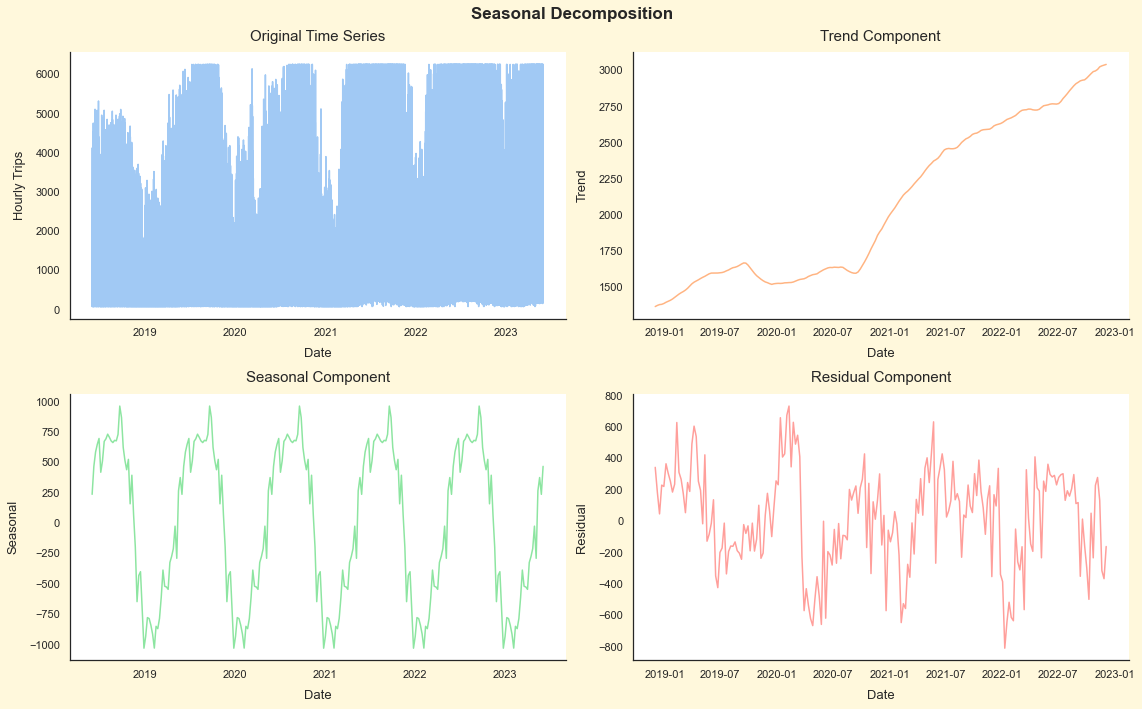

In [7]:
# Perform seasonal decomposition
decomp = seasonal_decompose(y.resample('W').mean())

plt.figure(figsize=(16, 10))

# Original time series
plt.subplot(2, 2, 1)
plt.plot(y.index, y['nyc_trips_all'], label='Original')
plt.xlabel('Date')
plt.ylabel('Hourly Trips')
plt.title('Original Time Series')

# Trend component
plt.subplot(2, 2, 2)
plt.plot(decomp.trend.index, decomp.trend, label='Trend', color=colors[1])
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('Trend Component')

# Seasonal component
plt.subplot(2, 2, 3)
plt.plot(decomp.seasonal.index, decomp.seasonal, label='Seasonal', color=colors[2])
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.title('Seasonal Component')

# Residual component
plt.subplot(2, 2, 4)
plt.plot(decomp.resid.index, decomp.resid, label='Residual', color=colors[3])
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residual Component')

# Adjust the layout and display the plot
plt.suptitle('Seasonal Decomposition', size=17, weight='bold')
plt.tight_layout()
plt.show()

---
## Analyze the residuals
---

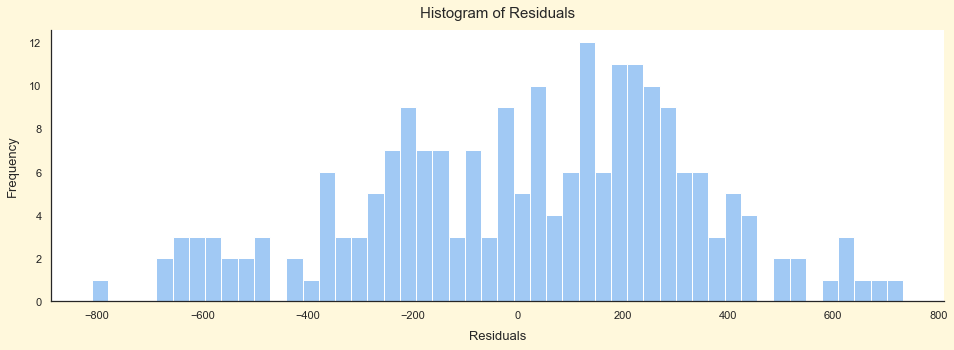

In [8]:
# Visualize the distribution of the residuals
plt.hist(decomp.resid, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [9]:
# Log-transform the target variable
y_log = np.log10(y)

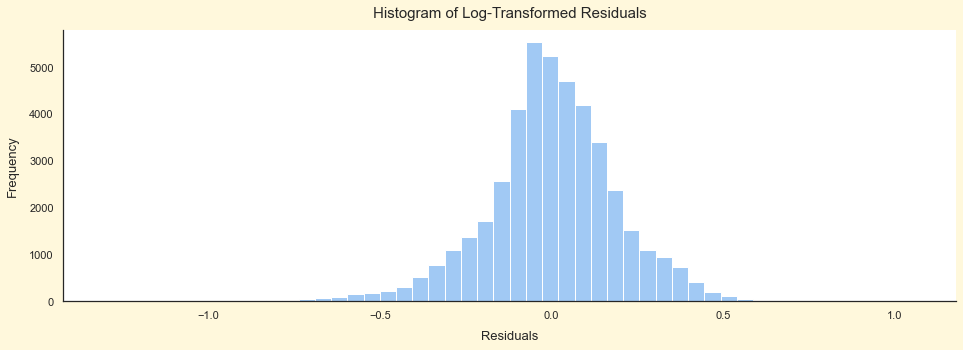

In [10]:
# Visualize the distribution of the log-transformed residuals
log_decomp = seasonal_decompose(y_log, period=24)
plt.hist(log_decomp.resid, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Log-Transformed Residuals')
plt.show()

---
## Plot the ACF and PACF
---

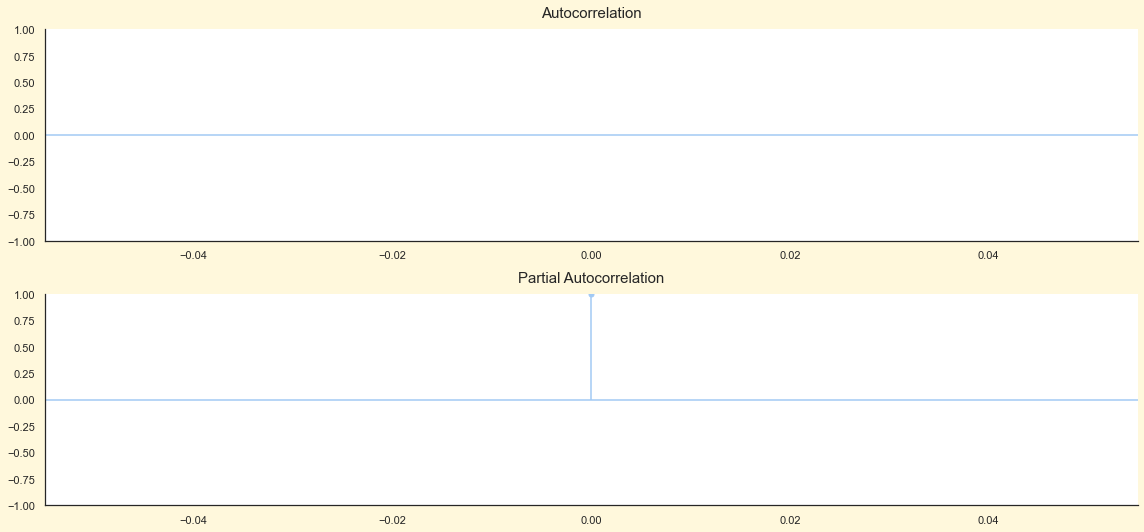

In [11]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 7.5))
plot_acf(log_decomp.resid, lags=50, ax=ax1)
plot_pacf(log_decomp.resid, lags=50, ax=ax2)

plt.tight_layout()
plt.show()

---
## Check the data's stationarity
---

In [12]:
# Perform Dickey-Fuller test
result = adfuller(y_log)

# Extract results
test_statistic = result[0]
p_value = result[1]
lags_used = result[2]
n_obs = result[3]
critical_values = result[4]
stationary = p_value < 0.05  # Check if the time series is stationary

# Print Dickey-Fuller test results
print(f"Dickey-Fuller Test Results:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Lags Used: {lags_used}")
print(f"Number of Observations Used: {n_obs}")
print(f"Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")
print(f"Stationary: {stationary}")

Dickey-Fuller Test Results:
Test Statistic: -9.200004287572737
P-value: 2.0139875603167595e-15
Lags Used: 53
Number of Observations Used: 43770
Critical Values:
	1%: -3.4304994101792583
	5%: -2.8616060360236197
	10%: -2.5668051488274246
Stationary: True


---
## Review the Variance-Inflation-Factor
---

In [13]:
# Review the VIF
get_vif(X_train)

,Variable,VIF
0,year,36.81
1,season,14.82
2,hour,12.48
3,weekday,8.78
4,bike_counts_log,8.31
5,month,8.23
6,nyc_bike_counts,6.52
7,season_sin,5.35
8,season_cos,4.32
9,temp,4.15


In [14]:
cols = ['year', 'season']
X_train.drop(cols, axis=1, inplace=True)
X_test.drop(cols, axis=1, inplace=True)

In [15]:
# Review the VIF
get_vif(X_train)

,Variable,VIF
0,bike_counts_log,7.50
1,hour,7.43
2,weekday,6.50
3,nyc_bike_counts,6.42
4,month,5.75
5,temp,4.11
6,season_sin,3.16
7,hour_sin,2.88
8,weekend,2.39
9,hour_cos,2.07


---
## Create the initial ARIMA model
---

In [16]:
# Create a DataFrame to store the model scores
model_scores = pd.DataFrame(columns=['AIC', 'MAPE', 'RMSE', 'Accuracy Rate'])

# Create the initial model
params = {'order': (1, 0, 0), 'seasonal_order': (1, 0, 0, 24)}
result, y_pred, model_scores.loc[len(model_scores)] = run_arima(params, X_train, X_test, y_train, y_test)

In [17]:
# Review the model results
model_scores

,AIC,MAPE,RMSE,Accuracy Rate
0,-76138.822227,26.695774,905.44262,73.304226


In [18]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                    nyc_trips_all   No. Observations:                35064
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 24)   Log Likelihood               38091.411
Date:                          Fri, 25 Aug 2023   AIC                         -76138.822
Time:                                  14:52:19   BIC                         -75952.594
Sample:                                       0   HQIC                        -76079.509
                                        - 35064                                         
Covariance Type:                            opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.9342      0.008    348.479      0.000       2.918       2.951
temp                0.0157      0.003      4.524      0.000       0.009       0.022
humidity            0.0050      0.001      3.521      0.000       0.002       0.008
precip             -0.0013      0.000     -3.122      0.002      -0.002      -0.000
windspeed           0.0009      0.001      1.612      0.107      -0.000       0.002
visibility          0.0105      0.000     21.154      0.000       0.010       0.012
nyc_bike_counts    -0.0192      0.002    -11.256      0.000      -0.023      -0.016
bike_counts_log     0.4844      0.002    261.221      0.000       0.481       0.488
hour               -0.0017      0.000     -9.402      0.000      -0.002      -0.001
weekday             0.0005      0.001      0.583      0.560      -0.001       0.002
month              -0.0001      0.001     -0.158      0.874      -0.002       0.002
weekend             0.0078      0.002      3.945      0.000       0.004       0.012
pandemic_period     0.0599      0.002     28.402      0.000       0.056       0.064
hour_sin           -0.0425      0.003    -16.038      0.000      -0.048      -0.037
hour_cos           -0.0749      0.003    -28.509      0.000      -0.080      -0.070
season_sin         -0.0136      0.004     -3.626      0.000      -0.021      -0.006
season_cos         -0.0065      0.003     -1.862      0.063      -0.013       0.000
rush_hour           0.0061      0.001      5.971      0.000       0.004       0.008
is_holiday          0.0012      0.001      1.142      0.254      -0.001       0.003
ar.L1               0.7312      0.002    363.830      0.000       0.727       0.735
ar.S.L24            0.4337      0.002    241.204      0.000       0.430       0.437
sigma2              0.0067   1.98e-05    336.097      0.000       0.007       0.007
===================================================================================
Ljung-Box (L1) (Q):                 222.14   Jarque-Bera (JB):            345327.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# Compile the forecast results
forecast = compile_forecast(y_test['nyc_trips_all'], y_pred)
display(forecast)

,Actual,Predicted,Residuals,Lower CI,Upper CI
date,,,,,
2022-06-01 00:00:00,908.00,625.925537,-282.074463,-1407.884265,782.979442
2022-06-01 01:00:00,445.00,260.514646,-184.485354,-1733.249767,406.317829
2022-06-01 02:00:00,287.00,131.646094,-155.353906,-1883.445335,361.647103
2022-06-01 03:00:00,175.00,88.133251,-86.866749,-1978.933699,252.322439
2022-06-01 04:00:00,244.00,116.260566,-127.739434,-1989.263498,331.076978
...,...,...,...,...,...
2023-05-31 19:00:00,6250.85,5108.803411,-1142.046589,3070.937010,5367.183697
2023-05-31 20:00:00,5614.00,3561.089787,-2052.910213,1494.474011,3730.607049
2023-05-31 21:00:00,3996.00,3090.782936,-905.217064,1046.669660,3400.737272


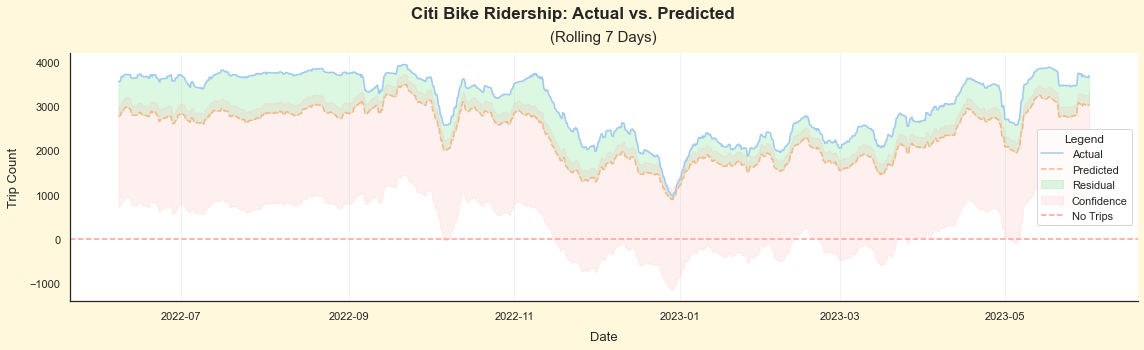

In [20]:
# Plot the actual vs predicted values
plot_forecast(forecast, 7)

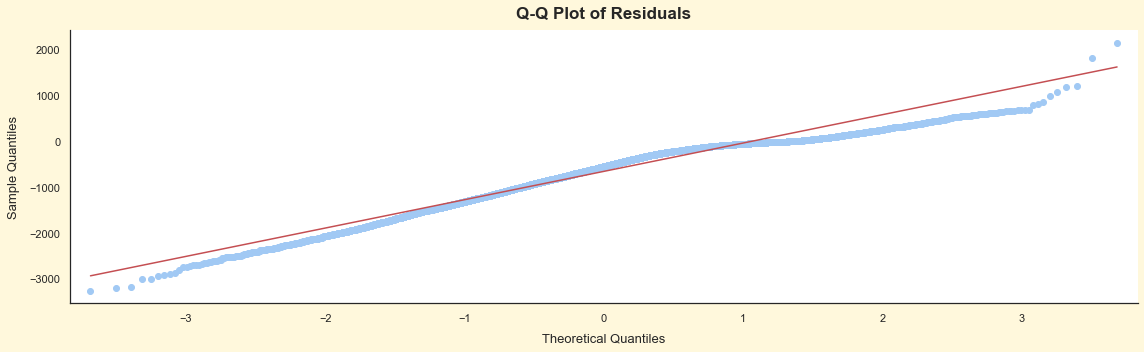

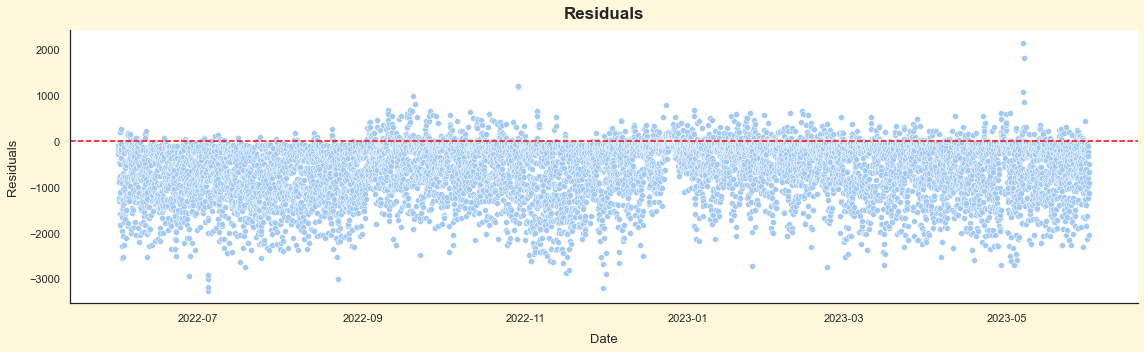

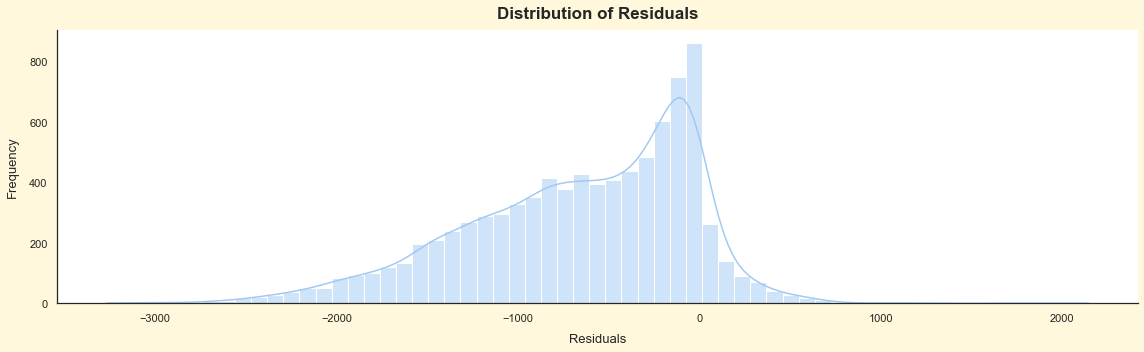

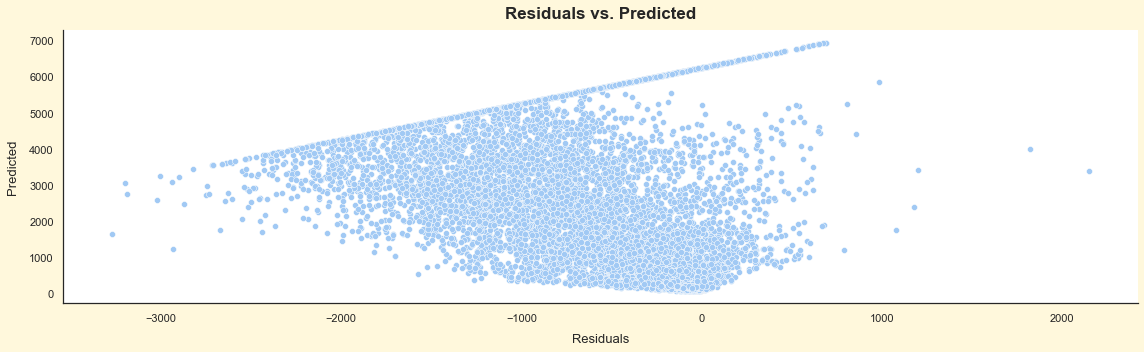

In [21]:
# Analyze the residuals
plot_residuals(forecast)

In [22]:
# Test the residual distribution
run_anderson(forecast)

Anderson-Darling Test Statistic: 121.68781576018046
15% significance level: Critical Value = 0.576, The residuals deviate from normality.
10% significance level: Critical Value = 0.656, The residuals deviate from normality.
5% significance level: Critical Value = 0.787, The residuals deviate from normality.
2% significance level: Critical Value = 0.918, The residuals deviate from normality.
1% significance level: Critical Value = 1.092, The residuals deviate from normality.


---
## Get feature importances
---

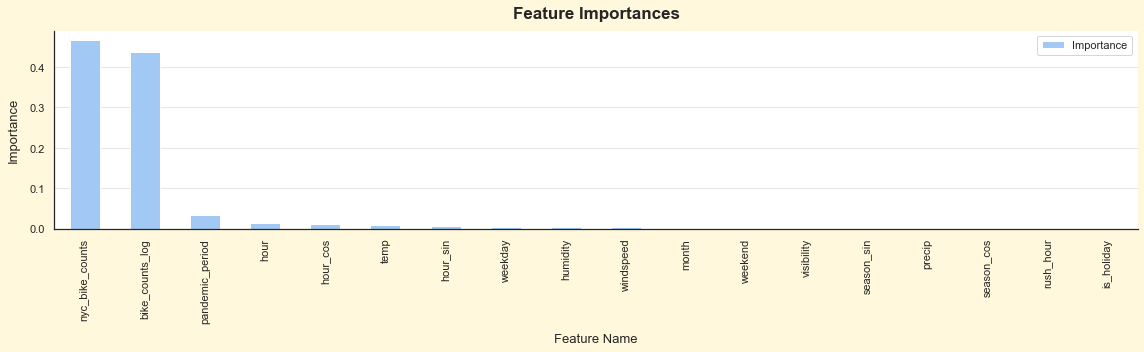

In [23]:
# Get the feature importances
feature_importance = get_feature_importance(X_train, y_train)

In [24]:
# Perform feature selection
best_model = select_features(feature_importance.index, X_train, X_test, y_train, y_test, params, model_type='arima')

,AIC,MAPE,RMSE,Accuracy Rate,features
0,-76138.516371,26.686641,904.965251,73.313359,"Index(['nyc_bike_counts', 'bike_counts_log', '..."
1,-76138.822228,26.695774,905.442620,73.304226,"Index(['nyc_bike_counts', 'bike_counts_log', '..."
2,-76040.706171,26.736371,909.522600,73.263629,"Index(['nyc_bike_counts', 'bike_counts_log', '..."
3,-76027.971516,26.751434,905.407072,73.248566,"Index(['nyc_bike_counts', 'bike_counts_log', '..."
4,-75734.194633,26.855417,907.516558,73.144583,"Index(['nyc_bike_counts', 'bike_counts_log', '..."
5,-75727.913302,26.866775,909.228605,73.133225,"Index(['nyc_bike_counts', 'bike_counts_log', '..."
6,-76036.079207,26.871152,914.137102,73.128848,"Index(['nyc_bike_counts', 'bike_counts_log', '..."
7,-76031.019329,26.886914,914.704340,73.113086,"Index(['nyc_bike_counts', 'bike_counts_log', '..."
8,-75741.316119,26.920416,910.179840,73.079584,"Index(['nyc_bike_counts', 'bike_counts_log', '..."
9,-75736.910700,26.928425,910.530779,73.071575,"Index(['nyc_bike_counts', 'bike_counts_log', '..."


In [25]:
# Store the model scores and select the best features
features = best_model['features']

In [26]:
# View the features
print("Best features:")
for f in features:
    print(f"    {f}")

Best features:
    nyc_bike_counts
    bike_counts_log
    pandemic_period
    hour
    hour_cos
    temp
    hour_sin
    weekday
    humidity
    windspeed
    month
    weekend
    visibility
    season_sin
    precip
    season_cos
    rush_hour


## Find the best forecast horizon
---

In [27]:
horizon_df = find_horizon(X[features], y['nyc_trips_all'], ordinal, params, model_type='arima')
display(horizon_df)

,Horizon Months,AIC,MAPE,RMSE,Accuracy Rate
0,6,-87634.81551,18.354361,517.808555,81.645639
1,5,-89230.058203,18.700048,583.369823,81.299952
2,7,-85841.100642,19.374934,559.028409,80.625066
3,8,-84013.295361,19.505186,589.633805,80.494814
4,9,-82228.700804,20.167857,635.16079,79.832143
5,4,-90846.979647,20.598935,706.152076,79.401065
6,10,-80287.485741,22.097966,717.873116,77.902034
7,11,-78316.046388,24.32942,811.27834,75.67058
8,3,-92582.920631,24.909217,894.732166,75.090783
9,12,-76417.374518,26.36427,892.018537,73.63573


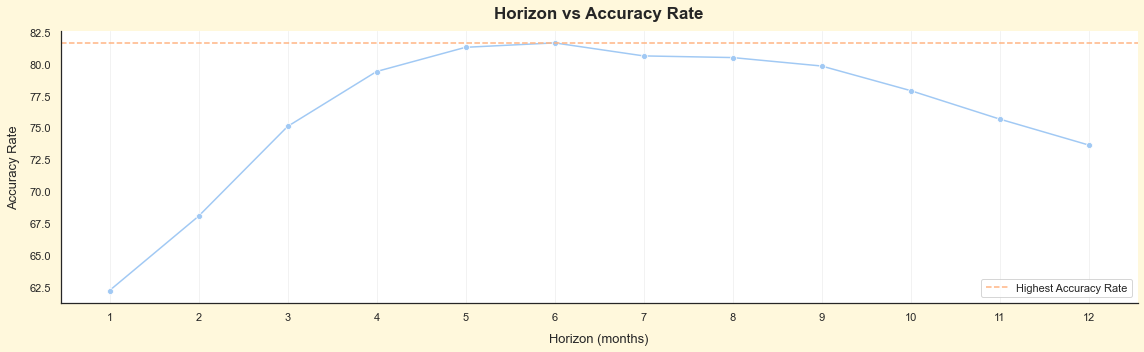

In [28]:
# Plot the RMSE for each forecast horizon
sns.lineplot(x='Horizon Months', y='Accuracy Rate', data=horizon_df, marker='o')
plt.axhline(y=horizon_df.at[0, 'Accuracy Rate'], linestyle='--', c=colors[1], label='Highest Accuracy Rate')

# Add titles and labels
plt.title('Horizon vs Accuracy Rate', size=17, weight='bold')
plt.xlabel('Horizon (months)')
plt.xticks(range(1, len(horizon_df) + 1))

plt.legend()
plt.grid(axis='x', alpha=0.25)
plt.tight_layout()
plt.show()

## Create a new model based on the forecast horizon
---

In [29]:
# Preprocess the data with the best horizon
best_horizon = horizon_df.at[0, 'Horizon Months'] * 30.04
X_train, X_test, y_train, y_test = preprocess_data(X[features], y, best_horizon, ordinal)

In [30]:
# Create and test the model
model, y_pred, scores = run_arima(params, X_train, X_test, y_train, y_test)

In [31]:
model_scores.loc[len(model_scores)] = scores
display(model_scores)

,AIC,MAPE,RMSE,Accuracy Rate
0,-76138.822227,26.695774,905.442620,73.304226
1,-87616.912567,18.344726,517.956633,81.655274


In [32]:
# Calculate the model's improvement
for col in model_scores.columns:
    previous = model_scores.at[0, col]
    current = model_scores.at[1, col]
    improvement = (current - previous) / previous * 100
    print(f'{col} Improvement: {improvement:.2f}%')

AIC Improvement: 15.08%
MAPE Improvement: -31.28%
RMSE Improvement: -42.80%
Accuracy Rate Improvement: 11.39%


In [33]:
# Calculate the confidence intervals
forecast = compile_forecast(y_test, y_pred)
forecast.describe()

,Actual,Predicted,Residuals,Lower CI,Upper CI
count,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000
mean,2628.175231,2547.128731,-81.046500,1321.660141,3564.609392
std,2012.473263,2012.727264,511.635661,2016.256995,2015.093032
min,74.000000,68.799236,-2111.109896,-1289.990984,889.095487
25%,711.000000,695.123103,-325.503357,-537.114487,1708.895931
50%,2354.000000,2254.847026,-40.158655,1020.696707,3269.582155
75%,4199.250000,3921.222238,146.645155,2708.230766,4948.371127
max,6250.850000,8025.794424,2909.709448,6838.692669,9100.234492


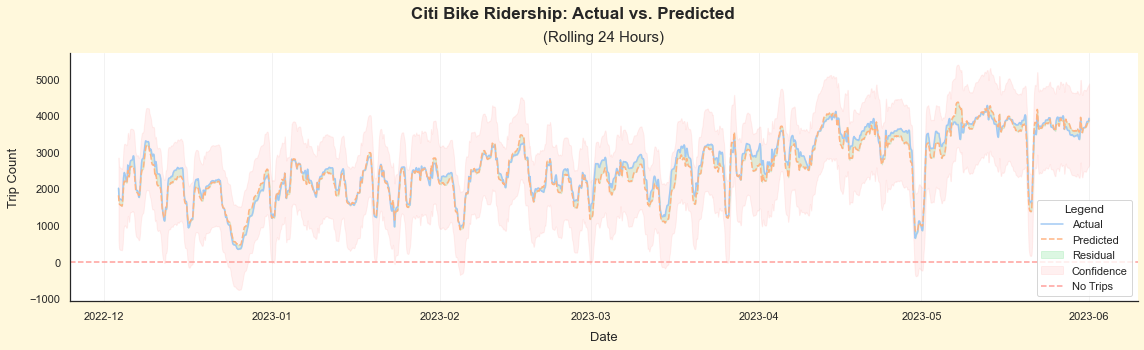

In [37]:
# Plot the actual vs predicted values
plot_forecast(forecast, 1)

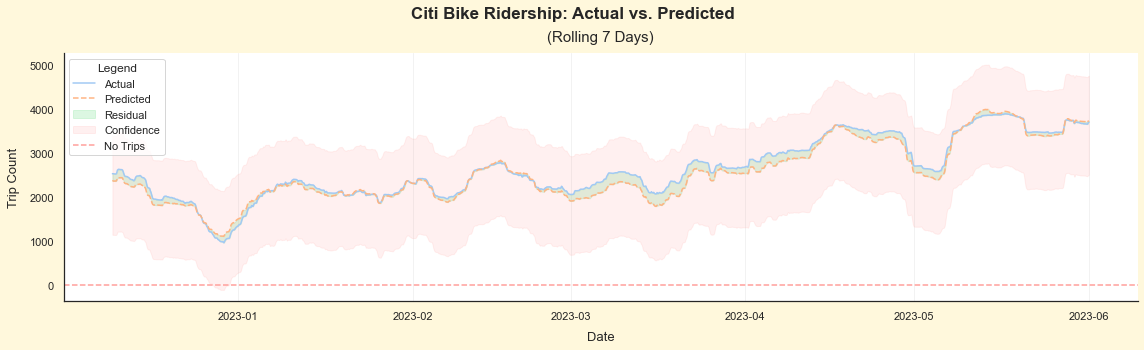

In [38]:
# Plot the actual vs predicted
plot_forecast(forecast, 7)

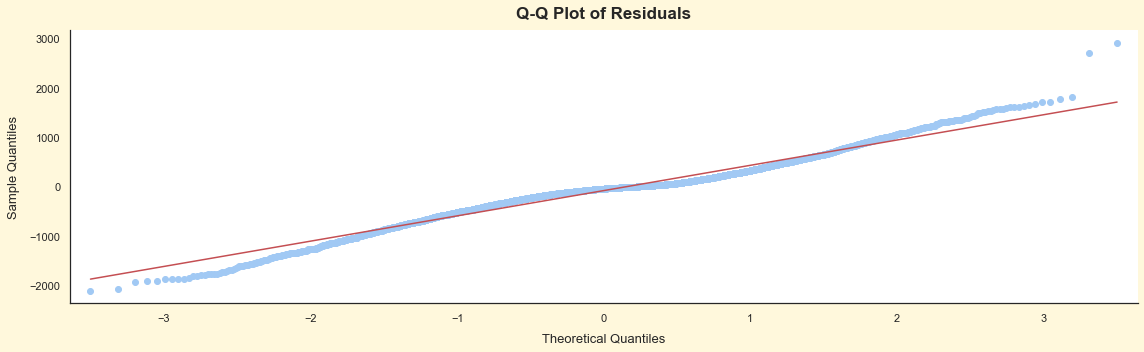

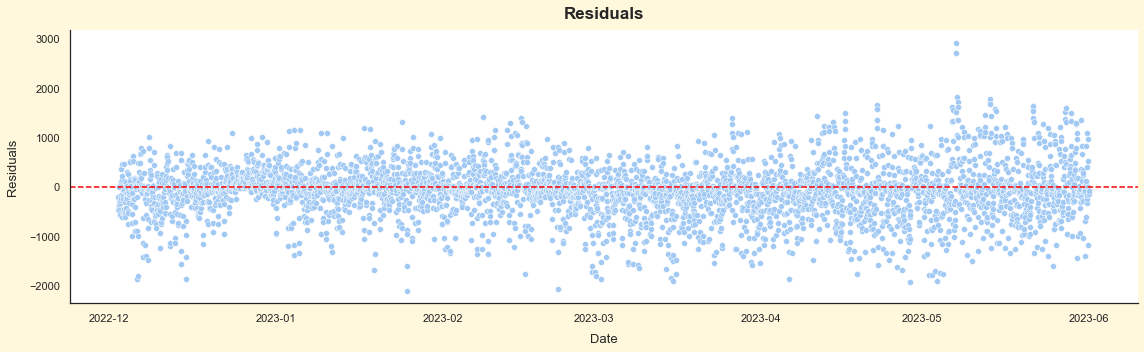

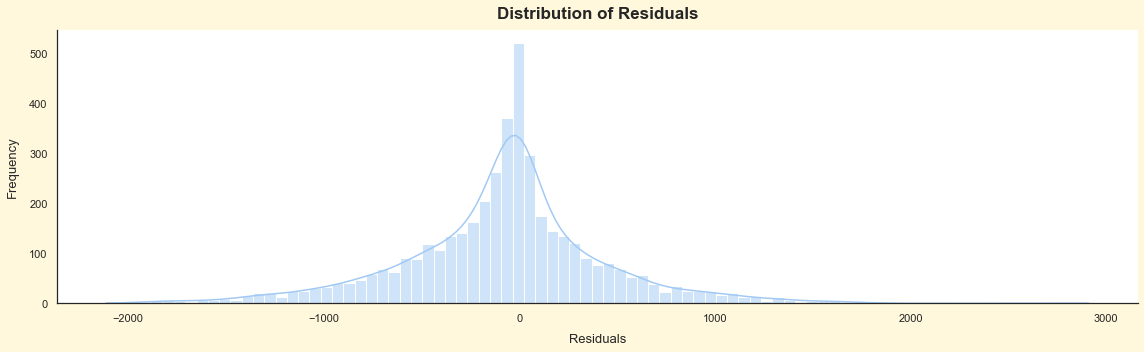

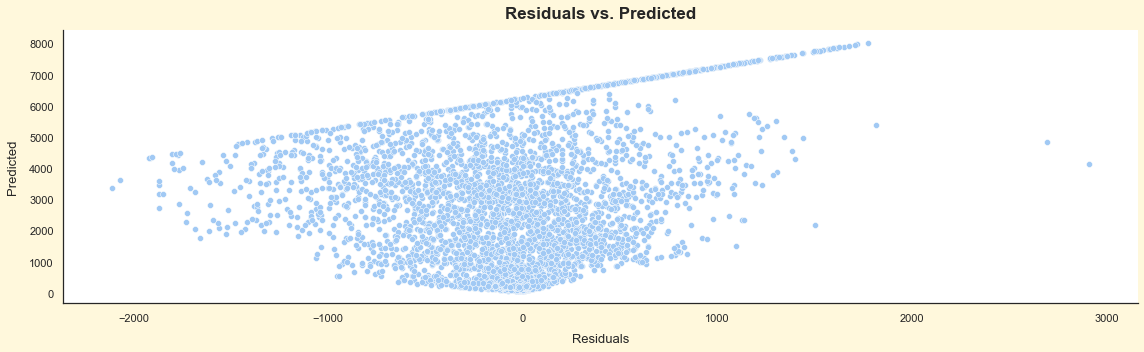

In [35]:
# Plot the residuals
plot_residuals(forecast)

In [36]:
# Test the residual distribution
run_anderson(forecast)

Anderson-Darling Test Statistic: 59.44810152446371
15% significance level: Critical Value = 0.575, The residuals deviate from normality.
10% significance level: Critical Value = 0.655, The residuals deviate from normality.
5% significance level: Critical Value = 0.786, The residuals deviate from normality.
2% significance level: Critical Value = 0.917, The residuals deviate from normality.
1% significance level: Critical Value = 1.091, The residuals deviate from normality.
